In [2]:
!pip install -q -U keras-tuner

In [1]:
# importing the library
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow import keras
import kagglehub
from fastai import *
import tensorflow as tf
import cv2
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
# Download latest version
path = kagglehub.dataset_download("rajumavinmar/finger-print-based-blood-group-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/finger-print-based-blood-group-dataset


In [4]:
dataset_path = os.path.join(path, "dataset_blood_group")

In [5]:
#Type of Blood Group
blood_group=['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']

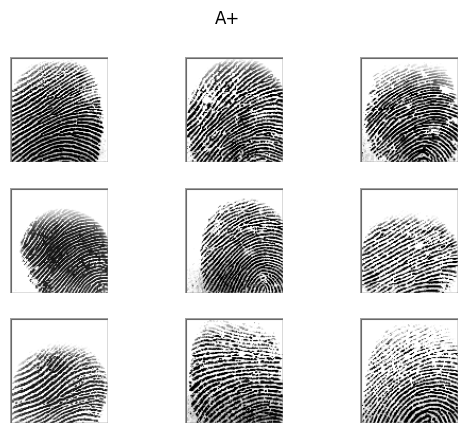

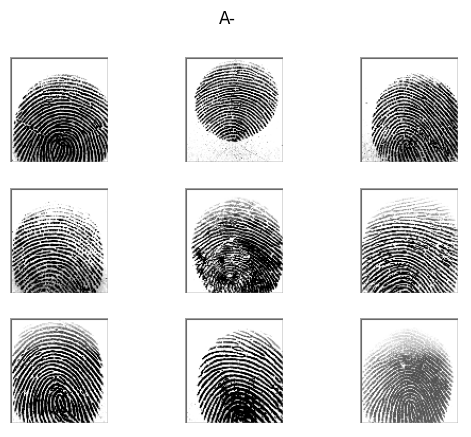

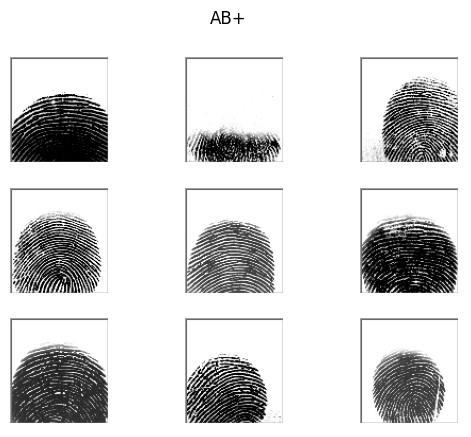

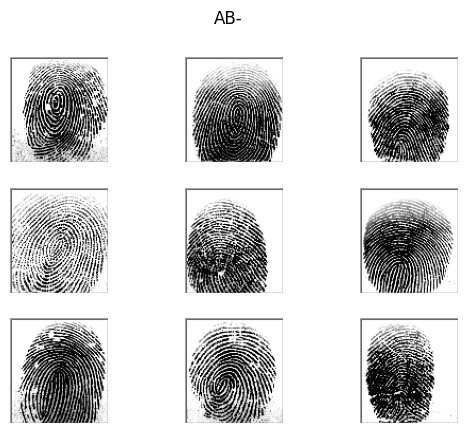

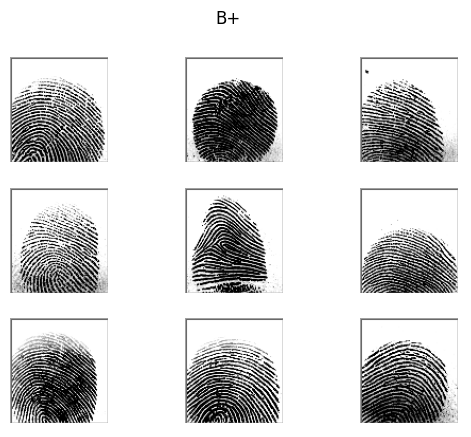

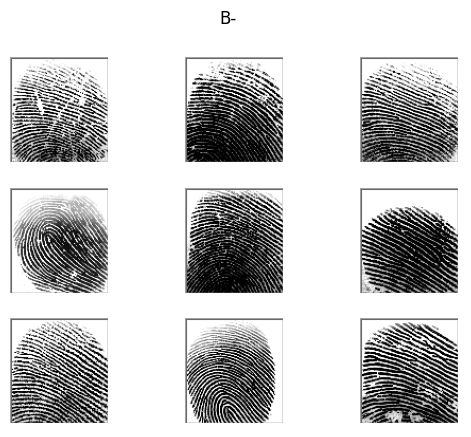

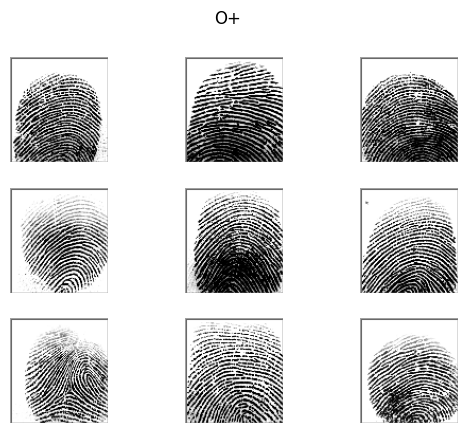

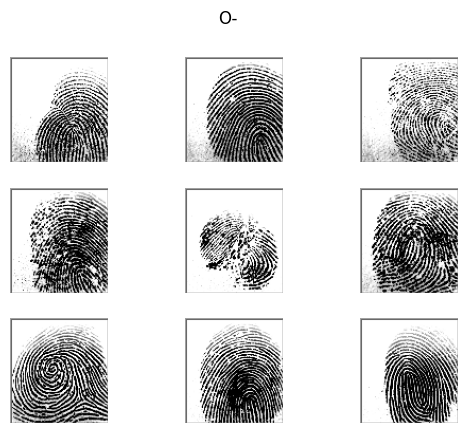

In [6]:
for blood in blood_group:
  fig, _ =plt.subplots(3, 3)
  fig.suptitle(blood)
  for k, n in enumerate(os.listdir(dataset_path+'/'+blood)[:9]):
    img=plt.imread(dataset_path+'/'+blood+'/'+n)
    plt.subplot(3,3,k+1)
    plt.axis('off')
    plt.imshow(img)
  plt.show()

In [7]:
feat=[]
names=[]
image_path=[]
height=128
width=128
n_channels=3

In [8]:
for k, blood in enumerate(blood_group):
  for f in os.listdir(dataset_path+'/'+blood):
    image_path.append([dataset_path+'/'+blood+'/'+f, k])

print(image_path)

[['/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/A+/cluster_0_1554.BMP', 0], ['/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/A+/cluster_0_994.BMP', 0], ['/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/A+/cluster_0_4617.BMP', 0], ['/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/A+/cluster_0_3270.BMP', 0], ['/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/A+/cluster_0_5366.BMP', 0], ['/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/A+/cluster_0_3134.BMP', 0], ['/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/A+/cluster_0_4840.BMP', 0], ['/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/A+/cluster_0_5286.BMP', 0], ['/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/A+/cluster_0_4399.BMP', 0], ['/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_grou

In [9]:
for imagepath in image_path:
  image=cv2.imread(imagepath[0])
  image=cv2.resize(image, (width, height))
  feat.append(image)

  name=imagepath[1]
  names.append(name)

In [10]:
feat=np.array(feat, dtype='float') / 255.0
names=np.array(names)

In [11]:
(x_train, x_test, y_train, y_test)=train_test_split(feat, names, test_size=0.2, random_state=13, stratify=names)

In [31]:
def model_builder(hp):
  # Choicing the right activation function with the help of tuner(hyperparameter finding library)
  activation1=hp.Choice("activation1",['relu','sigmoid','softmax'])
  # Finding the right learning rate
  hp_learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
  # Finding the Dropout
  dropout_rate=hp.Float('dropout', 0, 0.5, step=0.1)
  # Finding the neurons number
  hp_units=hp.Int('units', min_value=32, max_value=128, step=32)
  #creating the model
  model=keras.Sequential()
  model.add(keras.layers.InputLayer((128, 128, 3)))
  model.add(keras.layers.Conv2D(filters=hp_units, kernel_size=(3,3), activation=activation1))
  model.add(keras.layers.MaxPool2D())
  model.add(keras.layers.Conv2D(filters=hp_units, kernel_size=(3,3), activation=activation1))
  model.add(keras.layers.MaxPool2D())
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(units=hp_units, activation=activation1))
  model.add(keras.layers.Dense(8, activation="softmax"))


  #model compiling
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [20]:
tuner=kt.Hyperband(model_builder,
                   objective='val_accuracy',
                   max_epochs=10,
                   factor=3,
                   directory='my_dir',
                   project_name="Hyper")

In [34]:
stop_early=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [22]:
tuner.search(x_train,y=y_train,epochs=50, validation_split=0.2,callbacks=[stop_early])

Trial 30 Complete [00h 00m 47s]
val_accuracy: 0.17395833134651184

Best val_accuracy So Far: 0.9125000238418579
Total elapsed time: 00h 17m 09s


In [23]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 96 and the optimal learning rate for the optimizer
is 0.00017879831499230929.



In [24]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.3674 - loss: 1.7049 - val_accuracy: 0.7906 - val_loss: 0.6258
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8127 - loss: 0.5353 - val_accuracy: 0.8302 - val_loss: 0.4572
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8714 - loss: 0.3445 - val_accuracy: 0.8729 - val_loss: 0.3337
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8929 - loss: 0.2793 - val_accuracy: 0.8677 - val_loss: 0.3253
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9097 - loss: 0.2430 - val_accuracy: 0.8885 - val_loss: 0.2779
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9472 - loss: 0.1768 - val_accuracy: 0.8750 - val_loss: 0.3192
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9675 - loss: 0.1267 - val_accuracy: 0.8802 - val_loss: 0.2766
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9645 - loss: 0.1152 - val_accu

In [25]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 22


In [26]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(x_train, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/22
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.2407 - loss: 1.9589 - val_accuracy: 0.6625 - val_loss: 1.0135
Epoch 2/22
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.7451 - loss: 0.7549 - val_accuracy: 0.8146 - val_loss: 0.4874
Epoch 3/22
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8522 - loss: 0.4299 - val_accuracy: 0.8406 - val_loss: 0.3897
Epoch 4/22
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8974 - loss: 0.3057 - val_accuracy: 0.8531 - val_loss: 0.3705
Epoch 5/22
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9056 - loss: 0.2603 - val_accuracy: 0.8490 - val_loss: 0.3699
Epoch 6/22
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9307 - loss: 0.2057 - val_accuracy: 0.8708 - val_loss: 0.3300
Epoch 7/22
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9469 - loss: 0.1654 - val_accuracy: 0.8635 - val_loss: 0.3289
Epoch 8/22
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9522 - loss: 0.1446 - val_accu

In [27]:
eval_result = hypermodel.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9052 - loss: 0.2418
[test loss, test accuracy]: [0.24994048476219177, 0.9058333039283752]


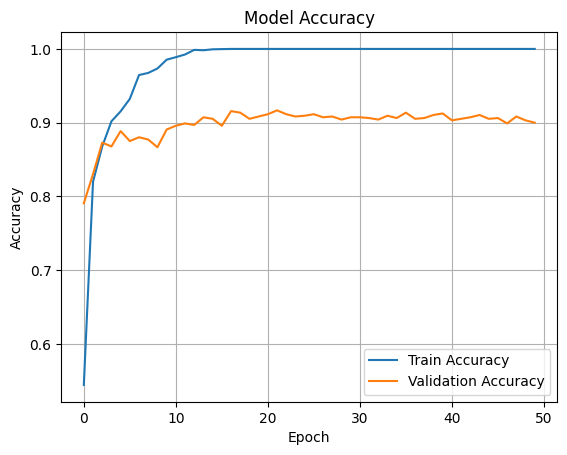

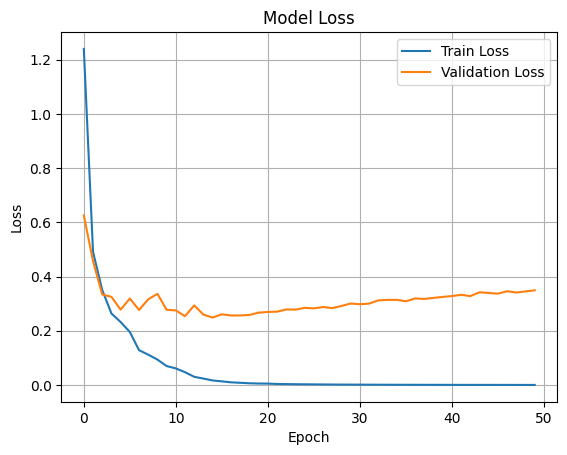

In [31]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
predictions=np.argmax(hypermodel.predict(x_test),axis=-1)
predicted_class=predictions[0]
print("Predicted class index:", predicted_class)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted class index: 1


In [46]:
print("Predicted index:", predicted_class)
print("Predicted blood group:", blood_group[predicted_class])

Predicted index: 1
Predicted blood group: A-


In [48]:
accuracy_score(y_test, predictions)

0.9058333333333334

In [49]:
hypermodel.save('my_model.keras')

In [14]:
from keras.models import load_model

In [15]:
model=load_model('my_model.keras')

### Prediction Space

In [16]:
def prediction_image(image_path):
  image=cv2.imread(image_path)
  image=cv2.resize(image,(128, 128))
  image=np.array(image, dtype='float') / 255.0
  image=np.expand_dims(image, axis=0)
  #print(image.shape)
  #print(image)
  return image

In [17]:
image_data_1="/content/cluster_7_2.BMP" # O- image

In [18]:
x=prediction_image(image_data_1)

In [19]:
predictions=np.argmax(model.predict(x), axis=-1)
predicted_class=predictions[0]
print("Predicted class index:", predicted_class)
print("Predicted blood group:", blood_group[predicted_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class index: 7
Predicted blood group: O-


In [20]:
y_probs= model.predict(x)

predicted_class=np.argmax(y_probs[0])
print("Predicted class index:", predicted_class)
print("Predicted blood group:", blood_group[predicted_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted class index: 7
Predicted blood group: O-


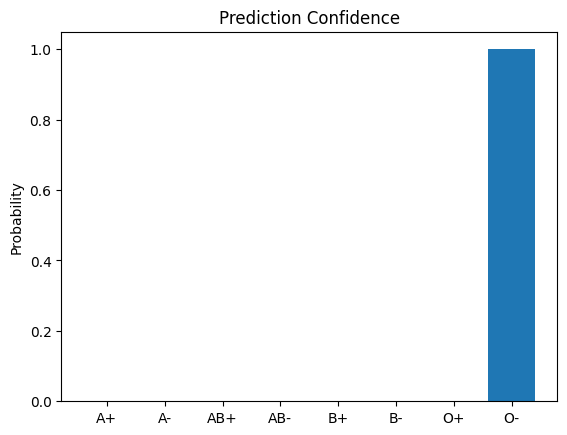

In [21]:
import matplotlib.pyplot as plt

plt.bar(blood_group, y_probs[0])
plt.title("Prediction Confidence")
plt.ylabel("Probability")
plt.show()

In [22]:
def model_prediction(image_path):
  image=prediction_image(image_path)
  y_probs=model.predict(image)
  predicted_class=np.argmax(y_probs[0])
  print("Predicted class index:", predicted_class)
  print("Predicted blood group:", blood_group[predicted_class])

  plt.bar(blood_group, y_probs[0])
  plt.title("Prediction Confidence")
  plt.ylabel("Probability")
  plt.show()

In [23]:
image2="/content/cluster_7_2.BMP" # O-

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted class index: 7
Predicted blood group: O-


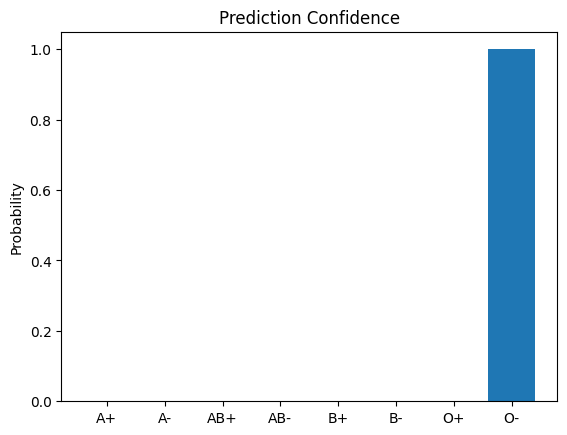

In [24]:
model_prediction(image2)

In [25]:
image3="/content/cluster_6_29.BMP" # O+

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted class index: 6
Predicted blood group: O+


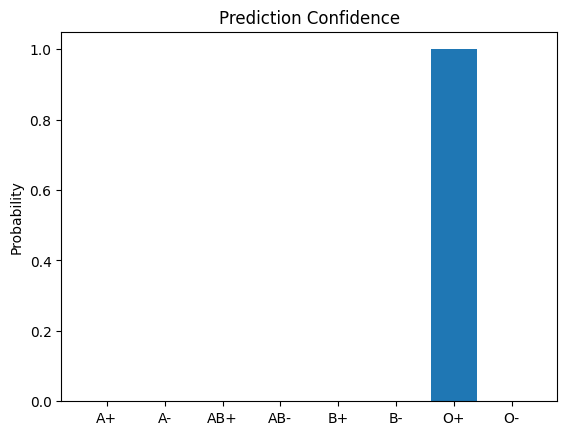

In [26]:
model_prediction(image3)

In [27]:
image4="/content/cluster_1_1.BMP" # A-

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Predicted class index: 1
Predicted blood group: A-


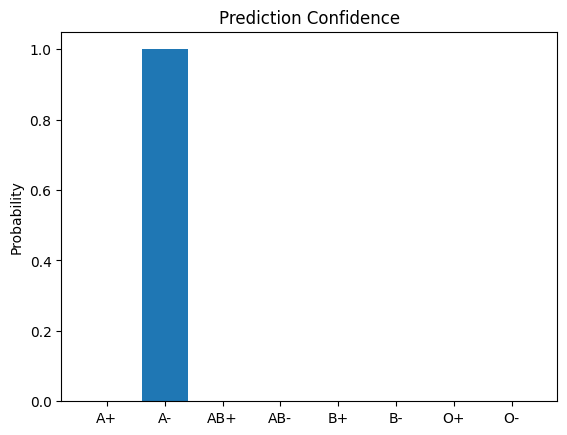

In [28]:
model_prediction(image4)